# 1. 환경 설정

In [1]:
import re
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 2. 데이터 준비

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

BATCH_SIZE = 16

IMAGE_SIZE = [180, 180]

EPOCHS = 40

In [3]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1088
Pneumonia images count in training set: 3097


In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [8]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['NORMAL' 'PNEUMONIA']


In [9]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"

In [10]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [13]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds_basic = prepare_for_training(train_ds)
val_ds_basic = prepare_for_training(val_ds)

In [15]:
# Augmentation

def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_aug_ds = prepare_for_training(train_ds)
val_aug_ds = prepare_for_training(val_ds)

# 3. 데이터 시각화

(16, 180, 180, 3)
(16,)


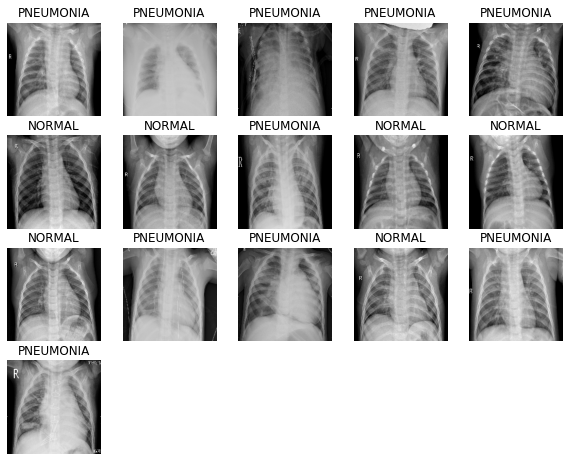

In [16]:
image_batch, label_batch = next(iter(train_ds_basic))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    print(image_batch.shape)
    print(label_batch.shape)
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

(16, 180, 180, 3)
(16,)


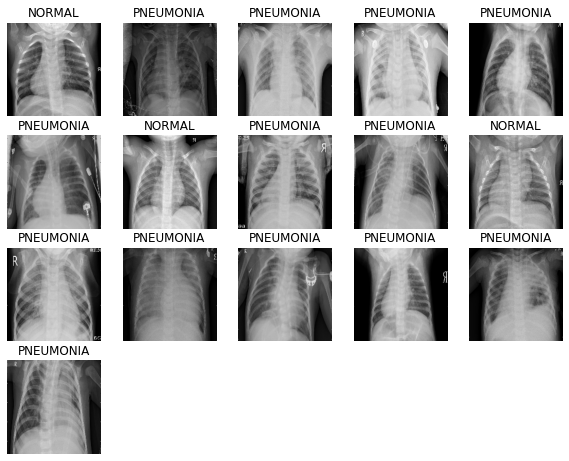

In [17]:
# Augmenatation visualization

image_aug_batch, label_aug_batch = next(iter(train_aug_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    print(image_batch.shape)
    print(label_batch.shape)
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_aug_batch.numpy(), label_aug_batch.numpy())

# 4. CNN 모델링

In [18]:
def conv_block(layer, filters):
    x = tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same')(layer)
    x = tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D()(x)

    return x

In [19]:
def dense_block(layer, units, dropout_rate=0.5, dropout=True):
    x = tf.keras.layers.Dense(units, activation='relu')(layer)
    x = tf.keras.layers.BatchNormalization()(x)
    if dropout:
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    return x

In [20]:
def build_model(dropout=True):
    input_layer = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    
    x = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(input_layer)
    x = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    
    x = conv_block(x, 32)
    x = conv_block(x, 64)
    
    x = conv_block(x, 128)
    if dropout:
        x = tf.keras.layers.Dropout(0.2)(x)
    
    x = conv_block(x, 256)
    if dropout:
        x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = dense_block(x, 512, 0.7)
    x = dense_block(x, 128, 0.5)
    x = dense_block(x, 64, 0.3)
    
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output)
    
    return model

# 5. 데이터 imbalance 처리

In [21]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.92
Weight for class 1: 0.68


# 6. 모델 훈련

### Basic

In [22]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [23]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds_basic,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_basic,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/40
261/261 [==============================] - 28s 106ms/step - loss: 0.3696 - accuracy: 0.8226 - precision: 0.9550 - recall: 0.7977 - val_loss: 0.6212 - val_accuracy: 0.7510 - val_precision: 0.7510 - val_recall: 1.0000
Epoch 2/40
261/261 [==============================] - 22s 86ms/step - loss: 0.2105 - accuracy: 0.9219 - precision: 0.9762 - recall: 0.9168 - val_loss: 1.0873 - val_accuracy: 0.7510 - val_precision: 0.7510 - val_recall: 1.0000
Epoch 3/40
261/261 [==============================] - 22s 85ms/step - loss: 0.2175 - accuracy: 0.9224 - precision: 0.9711 - recall: 0.9227 - val_loss: 0.0993 - val_accuracy: 0.9625 - val_precision: 0.9768 - val_recall: 0.9731
Epoch 4/40
261/261 [==============================] - 22s 85ms/step - loss: 0.1771 - accuracy: 0.9373 - precision: 0.9797 - recall: 0.9347 - val_loss: 0.4344 - val_accuracy: 0.8635 - val_precision: 0.9969 - val_recall: 0.8207
Epoch 5/40
261/261 [==============================] - 22s 85ms/step - loss: 0.1579 - accuracy: 

261/261 [==============================] - 46s 175ms/step - loss: 0.0437 - accuracy: 0.9861 - precision: 0.9967 - recall: 0.9844 - val_loss: 0.0610 - val_accuracy: 0.9788 - val_precision: 0.9810 - val_recall: 0.9910
Epoch 38/40
261/261 [==============================] - 46s 178ms/step - loss: 0.0257 - accuracy: 0.9923 - precision: 0.9981 - recall: 0.9916 - val_loss: 0.1343 - val_accuracy: 0.9760 - val_precision: 0.9809 - val_recall: 0.9872
Epoch 39/40
261/261 [==============================] - 46s 176ms/step - loss: 0.0557 - accuracy: 0.9808 - precision: 0.9944 - recall: 0.9794 - val_loss: 0.0642 - val_accuracy: 0.9846 - val_precision: 0.9873 - val_recall: 0.9923
Epoch 40/40
261/261 [==============================] - 46s 178ms/step - loss: 0.0329 - accuracy: 0.9887 - precision: 0.9971 - recall: 0.9877 - val_loss: 0.0412 - val_accuracy: 0.9856 - val_precision: 0.9923 - val_recall: 0.9884


In [24]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 5s 120ms/step - loss: 1.5180 - accuracy: 0.7564 - precision: 0.7212 - recall: 0.9949


### Augmentation

In [25]:
with tf.device('/GPU:0'):
    model_aug = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_aug.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [27]:
with tf.device('/GPU:0'):
    history_aug = model_aug.fit(
        train_aug_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=10,
        validation_data=val_aug_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 52s 199ms/step - loss: 0.1653 - accuracy: 0.9432 - precision: 0.9811 - recall: 0.9414 - val_loss: 0.0728 - val_accuracy: 0.9750 - val_precision: 0.9871 - val_recall: 0.9796
Epoch 2/10
261/261 [==============================] - 51s 195ms/step - loss: 0.1718 - accuracy: 0.9377 - precision: 0.9800 - recall: 0.9350 - val_loss: 0.0837 - val_accuracy: 0.9712 - val_precision: 0.9642 - val_recall: 0.9987
Epoch 3/10
261/261 [==============================] - 51s 194ms/step - loss: 0.1387 - accuracy: 0.9437 - precision: 0.9834 - recall: 0.9398 - val_loss: 0.0848 - val_accuracy: 0.9644 - val_precision: 0.9844 - val_recall: 0.9679
Epoch 4/10
261/261 [==============================] - 51s 195ms/step - loss: 0.1239 - accuracy: 0.9533 - precision: 0.9872 - recall: 0.9492 - val_loss: 0.3046 - val_accuracy: 0.8865 - val_precision: 1.0000 - val_recall: 0.8489
Epoch 5/10
261/261 [==============================] - 51s 194ms/step - loss: 0.1361 - accura

In [28]:
loss, acc, prec, rec = model_aug.evaluate(test_ds)

39/39 [==============================] - 5s 123ms/step - loss: 1.3683 - accuracy: 0.7708 - precision: 0.7398 - recall: 0.9769


# 7. 결과 확인과 시각화

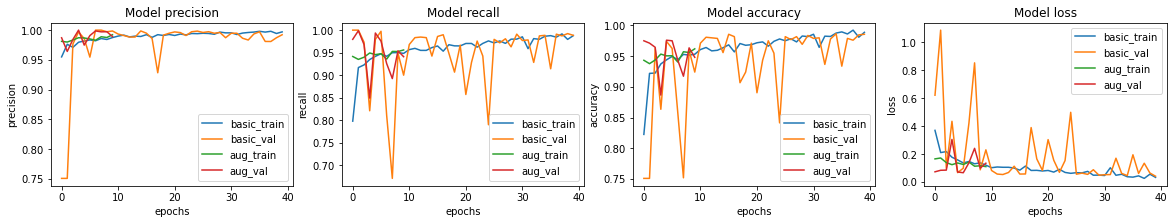

In [29]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].plot(history_aug.history[met])
    ax[i].plot(history_aug.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['basic_train', 'basic_val', 'aug_train', 'aug_val'])

accuracy 0.7708로 augmentation을 이용한 모델이 기본 모델보다 더 높게 나왔다.   
계속 수정하다보니 제출 시간에 맞춰서 augmentation epoch을 10으로 줄여서 했는데 epoch 수를 40으로 하고 조금 수정했으면 accuracy가 높아졌을 것이라 생각한다.   